# Comparative Baselines
WIll be used to compare our model
We will use same temporal split of initial dataset. Thus making sure we do not train on future data.

In [1]:
# Import all paths and helpers from before
import os, json, joblib, numpy as np, scipy.sparse as sp
import torch, dgl
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score, precision_recall_fscore_support
from pathlib import Path

# Reuse project modules
from feature_store import fetch_edge_features
from eval_utils import make_eval_loader, map_store_global_to_graph_local   # eval dataloader & mapping
from eval_infer import infer_split                                         # logits->probs for GCN baseline
from eval_metrics import compute_metrics                                   # macro metrics & FAR
from eval_roc import plot_roc_ovr, false_negatives_by_class                # optional plots

device = "cuda" if torch.cuda.is_available() else "cpu"

FS_TRAIN = "feature_store/train"
FS_VAL   = "feature_store/val"
GRAPH_TRAIN = "graphs/train.bin"
GRAPH_VAL   = "graphs/val.bin"

# label map
with open("artifacts/label_map.json","r",encoding="utf-8") as f:
    label2id = json.load(f)
id2label = {v:k for k,v in label2id.items()}
classes  = [id2label[i] for i in range(len(id2label))]
num_classes = len(classes)

# 1. XGBoost baseline


In [2]:
# Load validation graph and create eval dataloader
# parameters
fanouts=(25,15)
batch_size=2048
g_val = dgl.load_graphs(GRAPH_VAL)[0][0]
val_loader = make_eval_loader(g_val, FS_VAL, fanouts=fanouts, batch_size=batch_size)

## Assemble training features for XGB

Two modes to choose from — depending on memory:
1) Fast/Light: stratified downsample from train split (e.g., 50k–200k edges), 601 features → fits in RAM
2) Full: using QuantileDMatrix, that we will use on a GPU with lots of RAM (optional)

In [3]:
rng = np.random.default_rng(42)

# Load split ids & labels from store/graph
g_train = dgl.load_graphs(GRAPH_TRAIN)[0][0]
y_train_all = g_train.edata["y"].cpu().numpy()
store_train_eids = np.load(os.path.join(FS_TRAIN, "edge_indices.npy")).astype(np.int64)

# Stratified sample per class
per_class = 40000   # adjust to 10k–100k depending on RAM
sample_idx = []
for c in range(num_classes):
    idx_c = np.where(y_train_all == c)[0]
    if idx_c.size == 0: 
        continue
    take = min(per_class, idx_c.size)
    sample_idx.append(rng.choice(idx_c, size=take, replace=False))
sample_idx = np.concatenate(sample_idx, axis=0)

# Fetch features (GLOBAL ids) and labels
global_ids = g_train.edata[dgl.EID][torch.from_numpy(sample_idx)].cpu().numpy().astype(np.int64)
X_train = fetch_edge_features(global_ids, FS_TRAIN).astype(np.float32, copy=False)
y_train = y_train_all[sample_idx].astype(np.int32)

print("X_train:", X_train.shape, "y_train:", y_train.shape, "classes:", np.unique(y_train).size)

X_train: (82459, 601) y_train: (82459,) classes: 10


## Build validation vectors for XGB


In [4]:
# We reuse val_loader to pull batches of GLOBAL EIDs and stack
X_val_list, y_val_list = [], []
with torch.no_grad():
    for input_nodes, pair_graph, blocks in val_loader:
        local_eids = pair_graph.edata[dgl.EID].cpu().numpy().astype(np.int64)
        global_eids = g_val.edata[dgl.EID][torch.from_numpy(local_eids)].cpu().numpy().astype(np.int64)
        Xb = fetch_edge_features(global_eids, FS_VAL).astype(np.float32, copy=False)
        yb = g_val.edata["y"][torch.from_numpy(local_eids)].cpu().numpy().astype(np.int32)
        # Drop unknown labels if any
        keep = (yb >= 0)
        if not np.all(keep):
            Xb = Xb[keep]; yb = yb[keep]
        X_val_list.append(Xb); y_val_list.append(yb)
X_val = np.vstack(X_val_list)
y_val = np.concatenate(y_val_list)
print("X_val:", X_val.shape, "y_val:", y_val.shape)

c:\Users\riko.lusa\src\phd-i4sec\.venv\Lib\site-packages\dgl\dataloading\dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(


X_val: (709628, 601) y_val: (709628,)


## Train XGBoost & evaluate

{
  "model": "XGBoost",
  "accuracy": 0.9729238417875281,
  "macro": {
    "precision": 0.7357013078596328,
    "recall": 0.5590091737708243,
    "f1": 0.6064437954053495
  },
  "macro_precision": 0.7357013078596328,
  "macro_recall": 0.5590091737708243,
  "macro_FAR": 0.0027836347982209955
}


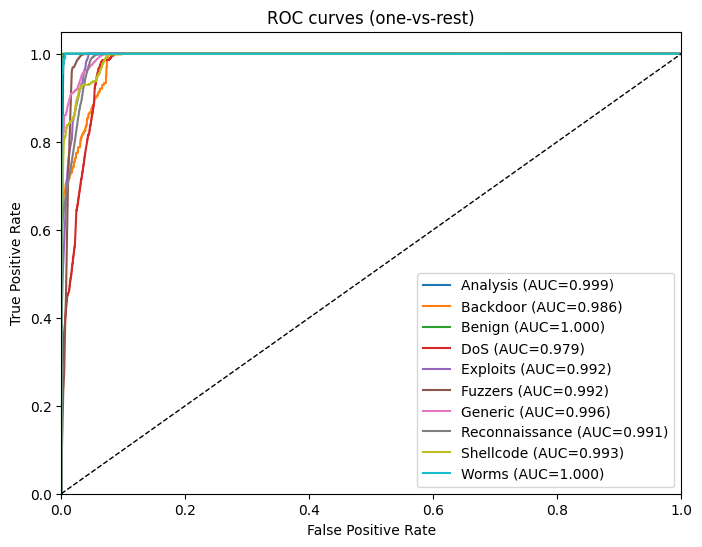

In [ ]:
import xgboost as xgb

tree_method = "hist"

xgb_model = xgb.XGBClassifier(
    n_estimators=600,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method=tree_method,
    device=device,
    n_jobs= max(1, os.cpu_count()//2),
    num_class=num_classes,
)

xgb_model.fit(X_train, y_train)
y_prob_xgb = xgb_model.predict_proba(X_val)            # (N, C)
y_pred_xgb = y_prob_xgb.argmax(axis=1)

# Metrics (reuse your helper)
metrics_xgb = compute_metrics(y_val, y_pred_xgb, label2id)

macro = metrics_xgb.get("macro", {})
print(json.dumps({
    "model": "XGBoost",
    "accuracy": metrics_xgb.get("accuracy"),
    "macro": macro,
    "macro_FAR": metrics_xgb.get("macro_FAR")
}, indent=2))

with open("artifacts/metrics_xgb.json", "w", encoding="utf-8") as f:
    json.dump({"model": "XGBoost", "metrics": metrics_xgb}, f, indent=2, ensure_ascii=False)
# Optional ROC / CM
plot_roc_ovr(y_val, y_prob_xgb, classes, out_path="artifacts/xgb_roc_val.png")


# 2. GCN Graph Baseline
We will use same edge head as for GraphSAGE

## Define a minimal GCN edge classifier

In [ ]:
# Minimal GCN baseline (2-layer GraphConv + edge MLP)
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn

class GCN_EdgeClassifier(nn.Module):
    def __init__(self, node_in: int, edge_in: int, hidden: int, num_classes: int, dropout: float=0.3):
        super().__init__()
        self.node_in = node_in
        if node_in > 0:
            self.feat_proj = nn.Linear(node_in, hidden)
        else:
            self.feat_proj = nn.Linear(1, hidden)   # constant feature if no node feats

        self.gcn1 = dglnn.GraphConv(hidden, hidden, norm="both", weight=True, bias=True, allow_zero_in_degree=True, activation=F.relu)
        self.gcn2 = dglnn.GraphConv(hidden, hidden, norm="both", weight=True, bias=True, allow_zero_in_degree=True, activation=None)
        self.dropout = nn.Dropout(dropout)

        self.edge_mlp = nn.Sequential(
            nn.Linear(2*hidden + edge_in, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, num_classes),
        )

    @torch.no_grad()
    def encode(self, blocks, x_nodes):
        # Node features: if empty, use a constant 1 per node
        if self.node_in > 0:
            h = self.feat_proj(x_nodes)
        else:
            h = self.feat_proj(torch.ones((blocks[0].num_src_nodes(), 1), device=blocks[0].device))
        h = self.gcn1(blocks[0], h)
        h = self.dropout(h)
        h = self.gcn2(blocks[1], h)  # (num_dst, hidden)
        return h

    def forward(self, blocks, x_nodes, pair_graph, e_feat):
        h_dst = self.encode(blocks, x_nodes)
        src_pos, dst_pos = pair_graph.edges()
        he = torch.cat([h_dst[src_pos], h_dst[dst_pos]], dim=1)  # (B, 2*hidden)
        logits = self.edge_mlp(torch.cat([he, e_feat], dim=1))
        return logits

## Create loaders for GCN baseline and eval

In [7]:
# Load graphs, loaders, and model for GCN baseline
# parameters
fanouts=(25,15)
batch_size=2048
hidden=128
dropout=0.3

edge_in = fetch_edge_features(np.load(os.path.join(FS_VAL, "edge_indices.npy"))[:1], FS_VAL).shape[1]

g_train = dgl.load_graphs(GRAPH_TRAIN)[0][0]
g_val   = dgl.load_graphs(GRAPH_VAL)[0][0]

train_loader_gcn = make_eval_loader(g_train, FS_TRAIN, fanouts=fanouts, batch_size=batch_size)
val_loader_gcn   = make_eval_loader(g_val,   FS_VAL,   fanouts=fanouts, batch_size=batch_size)

model_gcn = GCN_EdgeClassifier(node_in=0, edge_in=edge_in, hidden=hidden, num_classes=num_classes, dropout=dropout).to(device)
opt = torch.optim.Adam(model_gcn.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


In [8]:
# GCN training loop 
epochs=10       # (10 epochs, or 20 depends on speed)

def run_epoch_gcn(model, loader, g, split_dir, device, opt=None):
    model.train(opt is not None)
    total_loss, total, correct = 0.0, 0, 0
    for input_nodes, pair_graph, blocks in loader:
        if blocks and (blocks[0].device.type != torch.device(device).type):
            blocks = [b.to(device) for b in blocks]
        pair_graph = pair_graph.to(device) if pair_graph.device.type != torch.device(device).type else pair_graph

        local_eids = pair_graph.edata[dgl.EID].cpu().numpy().astype(np.int64)
        global_eids = g.edata[dgl.EID][torch.from_numpy(local_eids)].cpu().numpy().astype(np.int64)

        x_edge_np = fetch_edge_features(global_eids, split_dir).astype(np.float32, copy=False)
        x_edge = torch.from_numpy(x_edge_np).to(device)
        # node features: constant or degrees; here constant via node_in=0
        x_nodes = None

        y = g.edata["y"][torch.from_numpy(local_eids)].to(device)
        keep = (y >= 0)
        if not torch.all(keep):
            y = y[keep]
            x_edge = x_edge[keep.cpu().numpy()]
            # re-build pair_graph subset (small overhead) or skip mini-batch:
            # easiest is to skip batches with any -1 for baseline
            if y.numel() == 0: 
                continue

        logits = model(blocks, x_nodes, pair_graph, x_edge)
        loss = criterion(logits, y)

        if opt is not None:
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        total_loss += loss.item() * y.size(0)
        total += y.size(0)
        correct += (logits.argmax(1) == y).sum().item()

    return total_loss/max(total,1), correct/max(total,1)

# Train 10 epochs (baseline)
for epoch in range(1, epochs+1):
    tr_loss, tr_acc = run_epoch_gcn(model_gcn, train_loader_gcn, g_train, FS_TRAIN, device, opt)
    print(f"Epoch {epoch} train loss={tr_loss:.4f} acc={tr_acc:.4f}")

c:\Users\riko.lusa\src\phd-i4sec\.venv\Lib\site-packages\dgl\dataloading\dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(


DGLError: There are 0-in-degree nodes in the graph, output for those nodes will be invalid. This is harmful for some applications, causing silent performance regression. Adding self-loop on the input graph by calling `g = dgl.add_self_loop(g)` will resolve the issue. Setting ``allow_zero_in_degree`` to be `True` when constructing this module will suppress the check and let the code run.

## Evaluate GCN baseline

In [ ]:
# Inference and metrics for GCN baseline
y_true_gcn, y_pred_gcn, y_prob_gcn = infer_split(model_gcn, val_loader_gcn, g_val, device, fetch_edge_features)
metrics_gcn = compute_metrics(y_true_gcn, y_pred_gcn, label2id)
macro_precision = macro.get("precision", None)
macro_recall = macro.get("recall", None)

print(json.dumps({
    "model":"GCN",
    "accuracy": metrics_gcn["accuracy"],
    "macro": metrics_gcn["macro"],
    "macro_FAR": metrics_gcn["macro_FAR"],
}, indent=2))

with open("artifacts/metrics_gcn.json", "w", encoding="utf-8") as f:
    json.dump({"model": "GCN", "metrics": metrics_gcn}, f, indent=2, ensure_ascii=False)
# Optional ROC / CM
plot_roc_ovr(y_val, y_prob_gcn, classes, out_path="artifacts/gcn_roc_val.png")

# Comparative results table

In [ ]:
# assemble comparison
import pandas as pd

rows = []
def row_from_metrics(name, m):
    macro = m["macro"]; 
    return {
        "Model": name,
        "Accuracy": m["accuracy"],
        "Macro Precision": macro["precision"],
        "Macro Recall": macro["recall"],
        "Macro F1": macro["f1"],
        "Macro FAR": m.get("macro_FAR", None),
    }

rows.append(row_from_metrics("XGBoost", metrics_xgb))
rows.append(row_from_metrics("GCN", metrics_gcn))

# Get SAGE metrics saved earlier as metrics_val.json:
if os.path.exists("artifacts/metrics_val.json"):
    try:
        with open("artifacts/metrics_val.json","r", encoding="utf-8") as f:
            raw = json.load(f)
        # tolerate wrapper {"model":..., "metrics": {...}}
        if isinstance(raw, dict) and "metrics" in raw and isinstance(raw["metrics"], dict):
            raw = raw["metrics"]
        # build a safe metrics dict with expected keys (fill missing with None)
        safe = {
            "accuracy": raw.get("accuracy", None),
            "macro": {
                "precision": raw.get("macro", {}).get("precision", None),
                "recall": raw.get("macro", {}).get("recall", None),
                "f1": raw.get("macro", {}).get("f1", None),
            },
            "macro_FAR": raw.get("macro_FAR", None)
        }
        rows.append(row_from_metrics("GraphSAGE", safe))
    except Exception as e:
        print(f"warning: could not load/normalize GraphSAGE metrics: {e}")

df_cmp = pd.DataFrame(rows)
df_cmp = df_cmp[["Model", "Accuracy", "Macro Precision", "Macro Recall", "Macro F1", "Macro FAR"]]
display(df_cmp)

# Save ready CSV
os.makedirs("artifacts", exist_ok=True)
df_cmp.to_csv("artifacts/Results_comparison.csv", index=False)
# Save LaTeX table
with open("artifacts/Results_comparison.tex","w") as f:
    f.write(df_cmp.to_latex(index=False, float_format="%.4f"))